Урок 2. CNN. Детектирование
---

**Домашнее задание**: Используя файл Web2.ipynb (он в полезных ссылках):

1. Вам нужно будет загрузить и оформить датасет котиков, собак https://www.kaggle.com/andrewmvd/dog-and-cat-detection
2. *Нужно будет произвести аугментацию данных
3. Затем обучить нейронную сеть на получившемся датасете

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Загрузка данных

In [2]:
images_path = Path('../input/dog-and-cat-detection/images')
anno_path = Path('../input/dog-and-cat-detection/annotations')


def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [3]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,cat,99,34,238,183
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,dog,183,92,291,259
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,dog,155,119,356,250
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,dog,193,85,305,179
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,dog,284,58,363,128
...,...,...,...,...,...,...,...,...
3681,../input/dog-and-cat-detection/images/Cats_Tes...,200,179,cat,1,73,110,178
3682,../input/dog-and-cat-detection/images/Cats_Tes...,300,238,cat,223,77,285,145
3683,../input/dog-and-cat-detection/images/Cats_Tes...,500,333,dog,187,1,468,256
3684,../input/dog-and-cat-detection/images/Cats_Tes...,500,359,cat,215,23,393,176


In [4]:
df_train['class'].value_counts()

dog    2498
cat    1188
Name: class, dtype: int64

# Преобразуем метки в классы

In [5]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,0,99,34,238,183
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,1,183,92,291,259
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,155,119,356,250
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,193,85,305,179
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,1,284,58,363,128


# Изменение размеров изображений и bounding box'ов

Поскольку для обучения модели компьютерного зрения изображения должны иметь одинаковый размер, нам необходимо изменить размер наших изображений и соответствующих им ограничивающих рамок. Изменить размер изображения просто, но изменить размер bounding box'a немного сложнее, потому что каждый прямоугольник зависит от изображения и его размеров.

Вот основаная идея:

Преобразуем bounding box в изображение(маску) того же размера что и соотвествующее этому прямоугольнику изображение. Эта маска будет просто иметь 0 для заднего фона и 1 для области покрывающей bounding box.

Сначала прочитаем изображение:Пока что пропустим

In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)



def crop(im, r, c, target_r, target_c): 
    """Вырезаем кусок с изображения"""
    return im[r:r+target_r, c:c+target_c]

def center_crop(x, r_pix=8):
    """Центральное вырезание """
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def transformsXY(path, bb, is_transforms):
    """Трансформируем нашу картинку"""
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

Применим все наши написанные функции:

In [7]:
IM_SIZE = 300

In [8]:
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,0,99,34,238,183,images_resized/Cats_Test2888.png,"[32.0, 94.0, 177.0, 228.0]"
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,1,183,92,291,259,images_resized/Cats_Test1617.png,"[66.0, 110.0, 186.0, 174.0]"
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,155,119,356,250,images_resized/Cats_Test83.png,"[95.0, 93.0, 199.0, 213.0]"
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,193,85,305,179,images_resized/Cats_Test899.png,"[68.0, 116.0, 143.0, 182.0]"
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,1,284,58,363,128,images_resized/Cats_Test1204.png,"[52.0, 170.0, 114.0, 217.0]"


Пример получившегося сэмпла

In [23]:
df_train.iloc[7:10]

,index,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
7,7,../input/dog-and-cat-detection/images/Cats_Tes...,334,500,0,67,18,185,166,images_resized/Cats_Test380.png,"[11.0, 60.0, 99.0, 166.0]"
8,8,../input/dog-and-cat-detection/images/Cats_Tes...,405,500,1,12,25,303,340,images_resized/Cats_Test1300.png,"[15.0, 9.0, 203.0, 224.0]"
9,9,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,1,206,24,363,170,images_resized/Cats_Test3380.png,"[19.0, 123.0, 135.0, 217.0]"


(375, 500, 3)


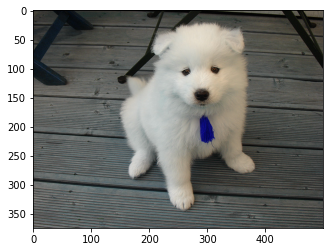

In [10]:
im = cv2.imread(str(df_train.values[9][0]))
bb = create_bb_array(df_train.values[9])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im);

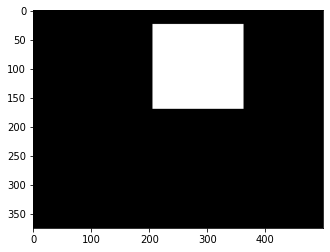

In [11]:
plt.imshow(Y, cmap='gray');

# Создадим датасет

In [12]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train)#, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

Загрузим все это в наш даталоадер:

In [13]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Определение модели

В качестве модели мы будем использовать очень простую предварительно обученную модель [resNet-34](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet34). Поскольку здесь у нас есть две задачи, есть два последних слоя - регрессия ограничивающей рамки и классификатор изображений.

In [14]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [15]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

# Обучение

Для расчета потерь нам нужно принять во внимание как потерю классификации, так и потерю регрессии ограничивающего прямоугольника, поэтому мы используем комбинацию кросс-энтропии и L1-потери (сумма всех абсолютных различий между истинным значением и прогнозируемыми координатами).

In [16]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 15
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [17]:
def train():
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [18]:
train()

Epoch [1/15]. train_loss 233.110 val_loss 142.514 val_acc 0.669
Epoch [2/15]. train_loss 141.180 val_loss 180.619 val_acc 0.630
Epoch [3/15]. train_loss 141.001 val_loss 139.615 val_acc 0.694
Epoch [4/15]. train_loss 139.541 val_loss 145.134 val_acc 0.673
Epoch [5/15]. train_loss 139.256 val_loss 187.678 val_acc 0.682
Epoch [6/15]. train_loss 138.701 val_loss 146.822 val_acc 0.694
Epoch [7/15]. train_loss 139.196 val_loss 135.788 val_acc 0.694
Epoch [8/15]. train_loss 138.520 val_loss 138.113 val_acc 0.690
Epoch [9/15]. train_loss 139.419 val_loss 139.569 val_acc 0.673
Epoch [10/15]. train_loss 137.297 val_loss 138.545 val_acc 0.694
Epoch [11/15]. train_loss 133.963 val_loss 132.932 val_acc 0.702
Epoch [12/15]. train_loss 130.034 val_loss 126.151 val_acc 0.694
Epoch [13/15]. train_loss 126.564 val_loss 122.462 val_acc 0.619
Epoch [14/15]. train_loss 122.640 val_loss 135.115 val_acc 0.690
Epoch [15/15]. train_loss 119.638 val_loss 135.068 val_acc 0.686


Трюк: мы можем после прохождения обучения изменить шаг обучения и продолжить:

In [20]:
for i, param_group in enumerate(optimizer.param_groups):
    param_group["lr"] = 0.001

In [21]:
train()

Epoch [1/15]. train_loss 115.135 val_loss 109.311 val_acc 0.672
Epoch [2/15]. train_loss 111.321 val_loss 109.567 val_acc 0.671
Epoch [3/15]. train_loss 109.648 val_loss 105.703 val_acc 0.687
Epoch [4/15]. train_loss 107.728 val_loss 103.742 val_acc 0.680
Epoch [5/15]. train_loss 106.220 val_loss 104.072 val_acc 0.692
Epoch [6/15]. train_loss 104.640 val_loss 102.827 val_acc 0.692
Epoch [7/15]. train_loss 103.829 val_loss 101.511 val_acc 0.694
Epoch [8/15]. train_loss 102.676 val_loss 99.649 val_acc 0.691
Epoch [9/15]. train_loss 102.223 val_loss 98.720 val_acc 0.688
Epoch [10/15]. train_loss 100.374 val_loss 96.659 val_acc 0.672
Epoch [11/15]. train_loss 98.226 val_loss 94.612 val_acc 0.690
Epoch [12/15]. train_loss 97.924 val_loss 97.826 val_acc 0.705
Epoch [13/15]. train_loss 95.501 val_loss 92.784 val_acc 0.701
Epoch [14/15]. train_loss 94.127 val_loss 90.779 val_acc 0.699
Epoch [15/15]. train_loss 92.196 val_loss 90.240 val_acc 0.703


# Тестирование

In [24]:
# resizing test image
image = 'Cats_Test1300'
im = read_image(f'./images_resized/{image}.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite(f'./road_signs_test/{image}.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [25]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':f'./road_signs_test/{image}.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 284])

In [26]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 0.9585,  1.5983, -7.1006, -7.4262]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 19.9071, 108.8514, 157.1909, 212.4157]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [27]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([1.5983], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

In [28]:
class_dict

{'cat': 0, 'dog': 1}

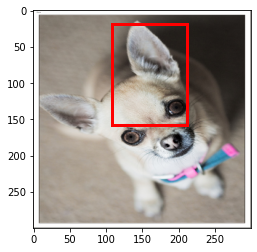

In [29]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])